In [1]:
import argparse
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_ddp, build_dp, compat_cfg, get_device,
                         setup_multi_processes, update_data_root)
from mmcv.parallel import MMDataParallel

In [2]:
# cfg
cfg = Config.fromfile('../configs/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco.py')

# epochs
# cfg.max_epochs = 100

cfg.img_scale = (3840//5, 2160//5)

# work_dir
cfg.work_dir = '../work_dirs/cascade'

# seed
# seed = init_random_seed(42)
# set_random_seed(seed, deterministic=True)
# cfg.seed = seed

cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
# gpu_ids
cfg.gpu_ids = [0]

# train
cfg.data.train.ann_file = '../data/aihub/train.json'
cfg.data.train.img_prefix = '../data/aihub/'
cfg.data.train.classes = ("선박", "기타부유물", "어망부표") # ("ship", "general float", "fishing net buoy")
cfg.data.train.pipeline[2]['img_scale'] = (2160//5, 3840//5)
cfg.data.train.pipeline[3]['flip_ratio'] = 0.0

# val
cfg.data.val.ann_file = '../data/aihub/valid.json'
cfg.data.val.img_prefix = '../data/aihub/'
cfg.data.val.classes = ("선박", "기타부유물", "어망부표")

# test
cfg.data.test.ann_file = '../data/aihub/train.json'
cfg.data.test.img_prefix = '../data/aihub/'
cfg.data.test.classes = ("선박", "기타부유물", "어망부표")
cfg.data.test.pipeline[1]['img_scale'] = (2160//5, 3840//5)

# cfg.model.bbox_head.num_classes = 3
cfg.model.roi_head.bbox_head[0].num_classes = 3
cfg.model.roi_head.bbox_head[1].num_classes = 3
cfg.model.roi_head.bbox_head[2].num_classes = 3

cfg.data.samples_per_gpu = 32

cfg.data.test.test_mode = True

# dataset = build_dataset
dataset = build_dataset(cfg.data.test)
# dataset
# next(iter(dataset))

data_loader = build_dataloader(
        dataset,
        samples_per_gpu=8,
        workers_per_gpu=8,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=3.00s)
creating index...
index created!


In [3]:
checkpoint_path = os.path.join(cfg.work_dir, 'best_bbox_mAP_epoch_3.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

output = single_gpu_test(model, data_loader)

load checkpoint from local path: ../work_dirs/cascade/best_bbox_mAP_epoch_3.pth
[                                                  ] 0/41829, elapsed: 0s, ETA:

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[>>>>>>>>>>>>>>>>>>>>>>>] 41829/41829, 26.3 task/s, elapsed: 1588s, ETA:     0s

In [4]:
import numpy as np

i = np.random.randint(0, len(dataset))
print(i)

output[i]

8302


[array([[3.27709741e+03, 1.10390552e+03, 3.57840845e+03, 1.32207642e+03,
         9.99813497e-01],
        [1.19427925e+02, 1.28031848e+03, 6.63420166e+02, 1.49093127e+03,
         9.99521255e-01],
        [0.00000000e+00, 1.28183960e+03, 1.55588943e+02, 1.50860840e+03,
         9.86496866e-01],
        [2.40022900e+03, 1.82150049e+03, 2.55997876e+03, 1.92689270e+03,
         4.71958101e-01]], dtype=float32),
 array([[2.4030632e+03, 1.8199691e+03, 2.5569492e+03, 1.9316567e+03,
         7.0507631e-02]], dtype=float32),
 array([[2.4030632e+03, 1.8199691e+03, 2.5569492e+03, 1.9316567e+03,
         5.6263924e-02]], dtype=float32)]

41829
41829


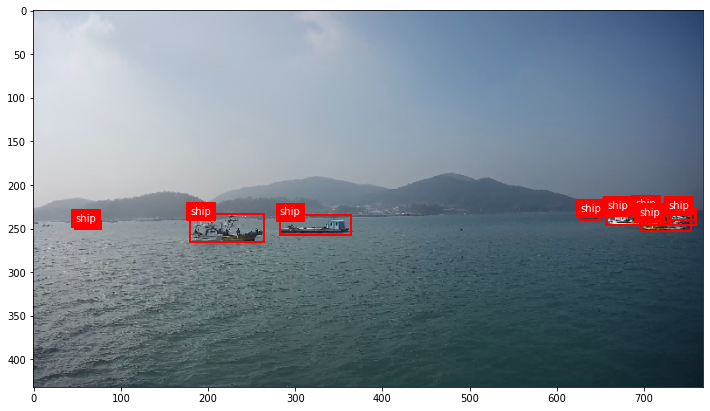

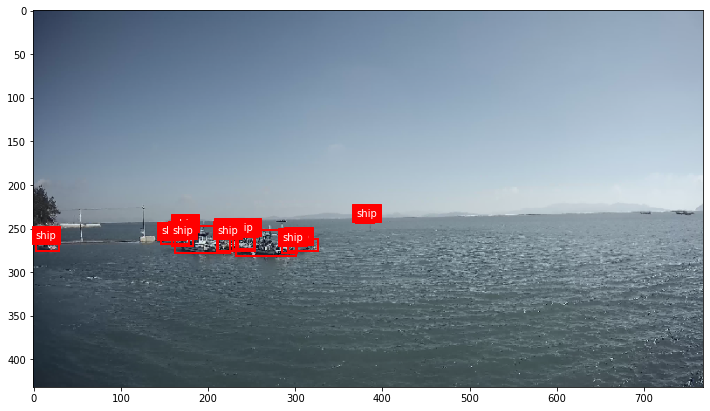

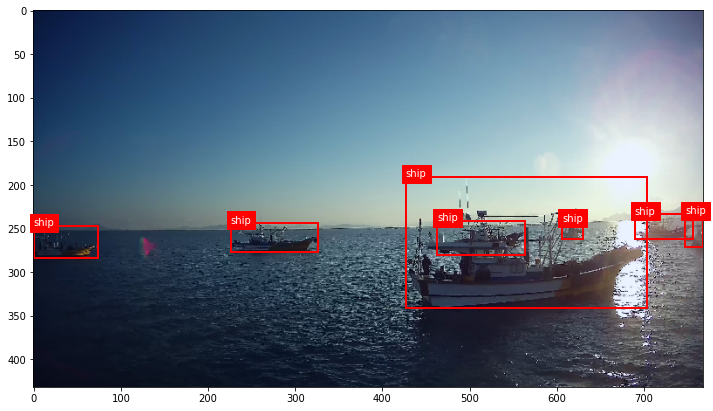

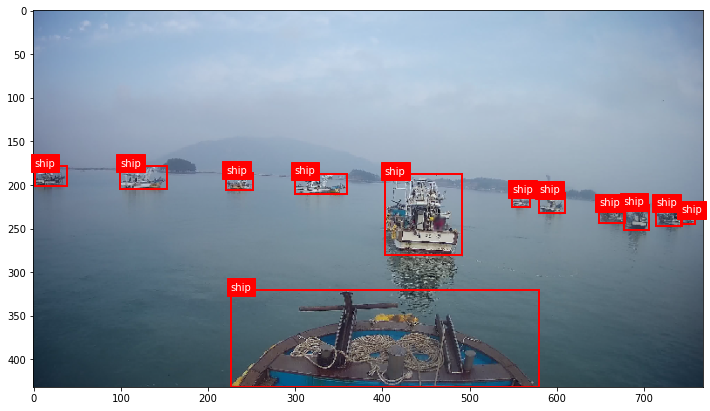

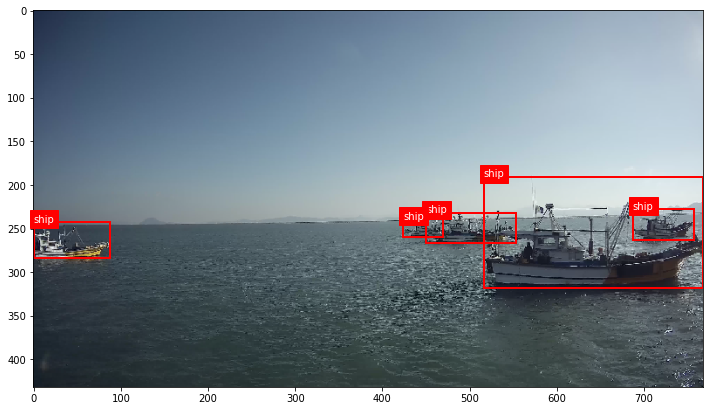

In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

print(len(output))
print(len(dataset))

idx_lst = [i for i in range(len(output))]
random.shuffle(idx_lst)

for count, i in enumerate(idx_lst):
    img = dataset[i]['img'][0].numpy()
    min_, max_ = np.min(img), np.max(img)
    img = img - (max_+min_)/2
    img = img / (max_-min_)
    img = img + 0.5
    img = np.transpose(img, (1, 2, 0))
    img = img[0:cfg.img_scale[1], 0:cfg.img_scale[0]]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    classes = ("ship", "general float", "fishing net buoy")
    color = ((1,0,0), (0,1,0), (0,0,1))
    for clss in range(len(classes)):
        for j in range(len(output[i][clss])):
            l, t, r, b, c = output[i][clss][j]
            l, t, r, b = int(l)/5, int(t)/5, int(r)/5, int(b)/5
            rect = mpl.patches.Rectangle((l, t), r-l, b-t, linewidth=2, edgecolor=color[clss], facecolor='none')
            ax.add_patch(rect)
            ax.text(x=l, y=t, s=classes[clss], fontsize=10, color='white', backgroundcolor=color[clss])
        
    plt.imshow(img)
    plt.show()
    
    if count==4:
        break